**Firstly grabbing our filtered dataset according to mappings**

In [1]:
# loading in our raw data
raw = spark.read.options(header=True,inferSchema=True).csv('airplane_raw')


# only selecting columns which we need
# also, we do not want flights which were cancelled (only valid flights or delays)
filtered_raw = raw.where(raw.Cancelled == 0).select('Year','Month','DayofMonth','Origin','Dest',\
                                                       'ArrDelay','DepDelay','ActualElapsedTime','Distance')
print(raw.printSchema())
#filtered_raw = filtered_raw.repartition(15)
# Got 116684126 records
#print(filtered_raw.count())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carr

In [2]:
# joining latitude and longitude values to the dataset
airport_metadata = spark.read.options(header=True,inferSchema=True).csv('./airplane_raw/metadata/airports.csv')
print(airport_metadata.printSchema())

filtered_raw = filtered_raw.join(airport_metadata.select('iata','lat','long')\
                             .withColumnRenamed('iata','Origin')\
                             .withColumnRenamed('lat','origin_lat')\
                             .withColumnRenamed('long','origin_long'), ['Origin'])

filtered_raw = filtered_raw.join(airport_metadata.select('iata','lat','long')\
                             .withColumnRenamed('iata','Dest')\
                             .withColumnRenamed('lat','dest_lat')\
                             .withColumnRenamed('long','dest_long'), ['Dest'])

print(filtered_raw.printSchema())

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)

None
root
 |-- Dest: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)

None


In [3]:
# loading or mapping from (year,month,day,airport) to id
airport_date_to_id_mapping = spark.read.parquet('./airport_date_to_id_mapping')
print(airport_date_to_id_mapping.printSchema())



# loading mapping from id to weather conditions
id_to_weather_mapping = spark.read.parquet('./id_to_weather_mapping')
print(id_to_weather_mapping.printSchema())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- Airport: string (nullable = true)
 |-- id: long (nullable = true)

None
root
 |-- id: long (nullable = true)
 |-- ACSH: long (nullable = true)
 |-- WSFM: long (nullable = true)
 |-- WSFG: long (nullable = true)
 |-- SNOW: long (nullable = true)
 |-- TMAX: long (nullable = true)
 |-- SNWD: long (nullable = true)
 |-- PRCP: long (nullable = true)
 |-- AWND: long (nullable = true)
 |-- ACMH: long (nullable = true)
 |-- ACMC: long (nullable = true)
 |-- TMIN: long (nullable = true)

None


In [4]:
# dropping columns in the mapping which we do not need

final_weather_mapping = id_to_weather_mapping.select('id','PRCP','TMAX','TMIN','AWND')\
                                             .where(\
                                             (id_to_weather_mapping.PRCP!=-9999) &     \
                                             (id_to_weather_mapping.TMAX!=-9999) & \
                                             (id_to_weather_mapping.TMIN!=-9999) & \
                                             (id_to_weather_mapping.AWND!=-9999) \
                                             )
print(final_weather_mapping.count())



1336772


In [5]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

# mapping location and day,time to ids in the raw df
filtered_raw = filtered_raw.join(airport_date_to_id_mapping.withColumnRenamed('Airport','Origin').withColumnRenamed('id','origin_id'), \
                                ['Year','Month','DayofMonth','Origin'])
filtered_raw = filtered_raw.join(airport_date_to_id_mapping.withColumnRenamed('Airport','Dest').withColumnRenamed('id','dest_id'), \
                                ['Year','Month','DayofMonth','Dest'])

# adding a dayOfYear column
@F.udf(returnType = T.StringType())
def date_string(year,month,day):
    return year+'-'+month+'-'+day

# 12-2 is winter =0, 3-5 is spring=1, 6-8 is summer=2, 9-11 is fall=3
@F.udf(returnType = T.IntegerType())
def map_month_to_season(month):
    if month in {12,1,2}:
        return 0
    elif month in {3,4,5}:
        return 1
    elif month in {6,7,8}:
        return 2
    else:
        return 3


# dropping the year, month, dayofMonth, Origin,and Dest columns, since we have their unique ids
#filtered_raw = filtered_raw.withColumn('Date',F.concat_ws("-",filtered_raw.Year,filtered_raw.Month,filtered_raw.DayofMonth).cast("date"))
#filtered_raw = filtered_raw.withColumn('Date', F.dayofyear(filtered_raw.Date)).withColumnRenamed('Date','DayOfYear')
filtered_raw = filtered_raw.withColumn('Season',map_month_to_season(filtered_raw.Month))
filtered_raw = filtered_raw.drop('Year','Month','DayofMonth','Origin','Dest')
print(filtered_raw.printSchema())
print(filtered_raw.take(1))

root
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- origin_id: long (nullable = true)
 |-- dest_id: long (nullable = true)
 |-- Season: integer (nullable = true)

None
[Row(ArrDelay='16', DepDelay='0', ActualElapsedTime='93', Distance='282', origin_lat=40.69249722, origin_long=-74.16866056, dest_lat=42.94052472, dest_long=-78.73216667, origin_id=85899346091, dest_id=146028888418, Season=0)]


In [6]:
from math import isnan
# checking exactly how many records with weather that we have

# below collects map of (id -> [Weather conditions])
collect_weather = final_weather_mapping.rdd.map(lambda x: (x['id'],(x['PRCP'],x['TMAX'],x['TMIN'],x['AWND']))).collectAsMap()

collect_weather_broadcast = sc.broadcast(collect_weather)

# basically just grabbing records which are valid
def test_good_records(record):
    if record['ArrDelay'] == 'NA':
        return False
    elif record['DepDelay'] == 'NA':
        return False
    elif record['ActualElapsedTime'] == 'NA':
        return False
    elif record['Distance']=='NA':
        return False
    elif isnan(record['origin_lat']):
        return False
    elif isnan(record['origin_long']):
        return False
    elif isnan(record['dest_lat']):
        return False
    elif isnan(record['dest_long']):
        return False
    elif record['Season']==None:
        return False
    return True


filtered_raw = \
                filtered_raw.rdd\
                             .filter(test_good_records)\
                             .filter(lambda x: x['origin_id'] in collect_weather_broadcast.value \
                             and x['dest_id'] in collect_weather_broadcast.value).toDF()

#print(filtered_raw.where(filtered_raw.ArrDelay == 'NA').count())
#print(filtered_raw.where(filtered_raw.ActualElapsedTime == 'NA').count())
# 95830696
print(filtered_raw.count())
# turning string columns into ints, so we can run BFR

filtered_raw = filtered_raw\
                           .withColumn('ArrDelay',filtered_raw.ArrDelay.cast('int'))\
                           .withColumn('DepDelay',filtered_raw.DepDelay.cast('int'))\
                           .withColumn('ActualElapsedTime',filtered_raw.ActualElapsedTime.cast('int'))\
                           .withColumn('Distance',filtered_raw.Distance.cast('int'))



95830696


In [7]:
# need to grab mean and std for each column so that we can normalize the df and apply clustering


joined = filtered_raw.join(final_weather_mapping.withColumnRenamed('id','origin_id'),'origin_id')\
                     .withColumnRenamed('PRCP','origin_prcp')\
                     .withColumnRenamed('TMAX','origin_tmax')\
                     .withColumnRenamed('TMIN','origin_tmin')\
                     .withColumnRenamed('AWND','origin_awnd')\
                     .join(final_weather_mapping.withColumnRenamed('id','dest_id'),'dest_id')\
                     .withColumnRenamed('PRCP','dest_prcp')\
                     .withColumnRenamed('TMAX','dest_tmax')\
                     .withColumnRenamed('TMIN','dest_tmin')\
                     .withColumnRenamed('AWND','dest_awnd')\
                     .drop('dest_id','origin_id')

columns = joined.columns
#print(joined.printSchema())

# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))

# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))

# lets write this data to parquet, just because
#joined.write.parquet('./FINAL_processed_data')


Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857405534, origin_long_mean=-92.27161607308402, dest_lat_mean=37.099157241985075, dest_long_mean=-92.26712071709842, Season_mean=1.4983448205364176, origin_prcp_mean=25.696228836739326, origin_tmax_mean=205.3709193033514, origin_tmin_mean=94.5765910747429, origin_awnd_mean=38.636158741871185, dest_prcp_mean=25.612486723460716, dest_tmax_mean=205.36587148443542, dest_tmin_mean=94.56188964755093, dest_awnd_mean=38.63819560488218, ArrDelay_stddev=30.939682127010062, DepDelay_stddev=28.437824166810316, ActualElapsedTime_stddev=70.31234179026455, Distance_stddev=569.0274209367313, origin_lat_stddev=5.599107569908229, origin_long_stddev=16.703784257869227, dest_lat_stddev=5.59970726731377, dest_long_stddev=16.697214735116198, Season_stddev=1.1130543679507285, origin_prcp_stddev=83.8530474281069, origin_tmax_stddev=105.31647

# Running PCR on our BFR clusters for values of k picked based on elbow plots

In [8]:
# defining some functions we will need
import numpy as np
# function to tag records with their cluster index (we will need it to run a sample on PCR)
# tagging records in BFR works with mahanalobis distance
#@F.udf(returnType = T.IntegerType())
def tag_record(x,centroids,stddevs):
    dist = None
    nearest_centroid = None
    for i,centroid in enumerate(centroids):
        comp_dist = np.sqrt(\
                       np.sum(\
                              np.square((x-centroid)/stddevs[i])\
                             ))
        if dist is None or comp_dist < dist:
            dist = comp_dist
            nearest_centroid = i
    return nearest_centroid

def tag_record_wrapped(centroids,stddevs):
    return F.udf(lambda c: tag_record(c,centroids,stddevs))

def get_centroid_stddev(centroids):
    use_centroids = []
    use_stddevs = []
    for i,centroid in enumerate(centroids):
        centroid_val = np.array(centroid[0])
        use_centroids.append(centroid_val)
        num = centroid[1]
        add_sum_examples = centroid[2]
        add_sum_squared_examples = centroid[3]
        for j in range(len(add_sum_squared_examples)):
                if add_sum_squared_examples[j] ==0 and add_sum_examples[j]!=0:
                    add_sum_examples[j]=0
        sum_val = np.array(add_sum_examples)
        sum_squared = np.array(add_sum_squared_examples)
        stddev = np.sqrt((sum_squared/num) - ((sum_val/num)**2))
        use_stddevs.append(stddev)
    return use_centroids,use_stddevs

## For season 0 (Winter) we choose k=8

In [9]:
from pyspark.sql.functions import struct, array
sample = joined.where(joined.Season == 0).drop('Season').sample(fraction=0.0001)
#print(sample.printSchema())
centers = spark.read.parquet('./BFR_Clusters/k=8_season=0')
print(centers.printSchema())
centroids = centers.toPandas().to_numpy()
# adding standard deviation for centroids
use_centroids,use_stddevs = get_centroid_stddev(centroids)


sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- centroid: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- num: long (nullable = true)
 |-- sum: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sum_squared: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [10]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.21580903 0.14677227]
[84.35783061 69.56849339]


In [11]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

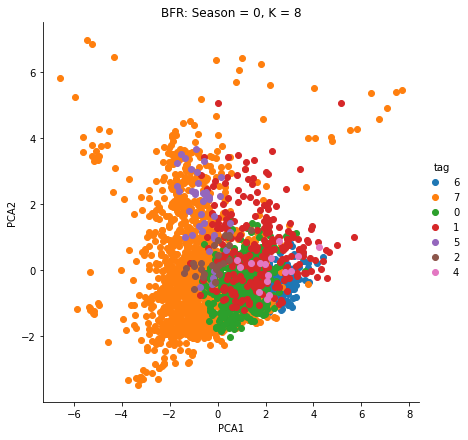

In [12]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 0, K = 8")
plt.show()

## For Spring (season =1 ) we also choose k=8

In [13]:

sample = joined.where(joined.Season == 1).drop('Season').sample(fraction=0.0001)
#print(sample.printSchema())
centers = spark.read.parquet('./BFR_Clusters/k=8_season=1')
print(centers.printSchema())
centroids = centers.toPandas().to_numpy()
# adding standard deviation for centroids
use_centroids,use_stddevs = get_centroid_stddev(centroids)


sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- centroid: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- num: long (nullable = true)
 |-- sum: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sum_squared: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [14]:

pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.17090481 0.14593768]
[76.08651952 70.30954714]


In [15]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

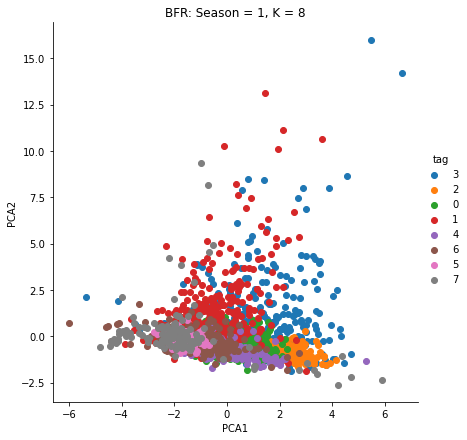

In [16]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 1, K = 8")
plt.show()

## For season=2, Summer, we choose k=8 as well

In [17]:

sample = joined.where(joined.Season == 2).drop('Season').sample(fraction=0.0001)
#print(sample.printSchema())
centers = spark.read.parquet('./BFR_Clusters/k=8_season=2')
print(centers.printSchema())
centroids = centers.toPandas().to_numpy()
# adding standard deviation for centroids
use_centroids,use_stddevs = get_centroid_stddev(centroids)


sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- centroid: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- num: long (nullable = true)
 |-- sum: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sum_squared: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [18]:

pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.22148526 0.17316054]
[84.09036707 74.35296633]


In [19]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

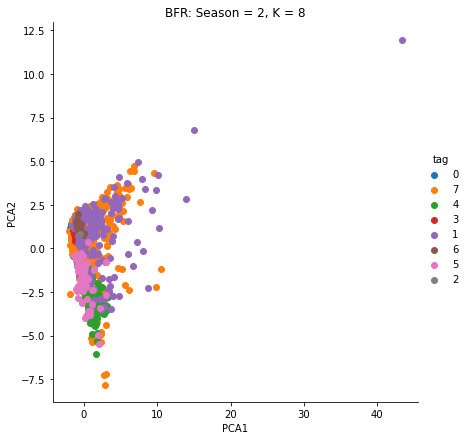

In [20]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 2, K = 8")
plt.show()

## For season=3, Fall, we choose k=7

In [21]:

sample = joined.where(joined.Season == 3).drop('Season').sample(fraction=0.0001)
#print(sample.printSchema())
centers = spark.read.parquet('./BFR_Clusters/k=7_season=3')
print(centers.printSchema())
centroids = centers.toPandas().to_numpy()
# adding standard deviation for centroids
use_centroids,use_stddevs = get_centroid_stddev(centroids)


sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- centroid: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- num: long (nullable = true)
 |-- sum: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sum_squared: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [22]:

pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.18367731 0.15537856]
[75.4936323  69.43494765]


In [23]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

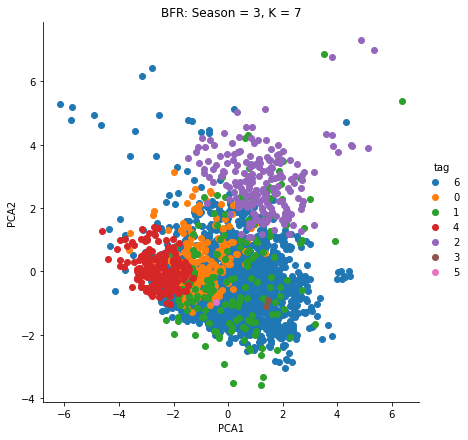

In [24]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR: Season = 3, K = 7")
plt.show()

## For season=Everything, which is all data, we choose k=8

In [33]:

sample = joined.drop('Season').sample(fraction=0.0001)
#print(sample.printSchema())
centers = spark.read.parquet('./BFR_Clusters/k=8_season=EVERYTHING')
print(centers.printSchema())
centroids = centers.toPandas().to_numpy()
# adding standard deviation for centroids
use_centroids,use_stddevs = get_centroid_stddev(centroids)


sample = sample.withColumn("tag", tag_record_wrapped(use_centroids,use_stddevs)(array([sample[col] for col in sample.columns])))
test = sample.toPandas().to_numpy()



root
 |-- centroid: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- num: long (nullable = true)
 |-- sum: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sum_squared: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [34]:

pca = PCA(2)
pca.fit(test[:,:-1])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.22287116 0.14174688]
[183.2339608  146.12878831]


In [35]:
pd_1 = pd.DataFrame(data = pca.transform(test[:,:-1]), columns=("PCA1","PCA2"))
pd_2 = pd.DataFrame(data = test[:,-1], columns=["tag"])

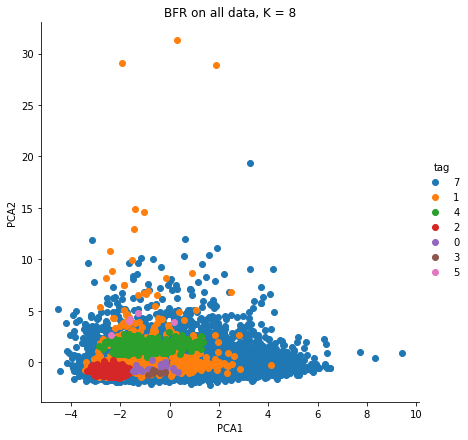

In [36]:
pca_data = pd.concat([pd_1,pd_2], axis=1)
sns.FacetGrid(pca_data,hue="tag", height=6).map(plt.scatter, "PCA1", "PCA2").add_legend()

plt.title("BFR on all data, K = 8")
plt.show()